## 0. API 이용해 시계열 데이터 불러오기

DataReader() 함수를 사용해 yahoo finance 에서 금융 시계열 데이터를 불러온다. <br>
금융 시장에 존재하는 모든 가격패턴을 얻기 위해 다양한 자산의 ETF가격 데이터를 활용한다. <br>

In [1]:
import pandas_datareader as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date



tickers = ["DBC", "DBA", "LQD", "TLT", "TIP", "XLB", "XLE", "SHY", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY"]
price_all = {}
start_date = "1950-01-02"
end_date = date.today()
for t in tickers:
  price_table = web.DataReader(t, "yahoo", start_date, end_date)
  price_all[t] = price_table["Close"]

# price_all["DBA"].plot()
# price_all["DBC"]

## 1. Functional Data Anlaysis로 금융 시장에 존재하는 가격패턴 분류


### 1.1 FDA 는 무엇인가?

### 1.2 금융시장에 존재하는 패턴 분류

#### 1.2.1 가격 패턴 데이터 만들기

다양한 금융시장 환경에서 존재하는 가격 패턴의 전체 집합을 만들기 위해 주식, 채권, 원자재 등 다양한 자산에 대해 12개월의 가격 데이터를 여러 구간별로 나누어서 만든다. <br>



##### **결측값 handling**
1. 자산별 비어있는 날짜의 데이터는 이전의 값으로 채운다.
2. ETF 상품별 시작일이 다르다. 동일한 시기에 존재하는 패턴 비교를 위해 길이가 가장 짧은 ETF를 기준으로 한다.

In [2]:
# Merge time series data frame
etf_price_df = pd.concat(price_all, axis=1, keys=tickers, join="outer")
filna_df = etf_price_df.fillna(method="ffill")
dropna_df = filna_df.dropna()
raw_price = dropna_df #dropna_df: original data
raw_price.head()

,DBC,DBA,LQD,TLT,TIP,XLB,XLE,SHY,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,
2007-01-05,23.100000,25.02,107.180000,89.209999,99.019997,34.220001,55.919998,80.070000,29.658813,34.959999,23.500000,26.139999,36.110001,33.689999,38.250000
2007-01-08,23.219999,24.98,107.150002,89.370003,99.089996,34.220001,55.919998,80.019997,29.788790,35.090000,23.570000,26.180000,36.090000,33.730000,38.310001
2007-01-09,23.020000,24.66,107.169998,89.370003,99.019997,34.230000,55.439999,80.050003,29.740049,35.070000,23.600000,26.240000,36.119999,33.689999,38.520000
2007-01-10,22.680000,24.73,107.029999,88.970001,98.769997,34.470001,54.369999,80.029999,29.837530,35.189999,23.719999,26.350000,36.130001,33.750000,38.720001
2007-01-11,22.650000,25.10,106.699997,88.449997,98.440002,34.840000,54.060001,79.970001,30.024370,35.480000,23.959999,26.549999,36.169998,34.119999,39.150002


##### **가격 스케일링**
각 ETF별 변동성이 달라 raw 데이터로 패턴 분류 시 변동성이 영향을 줄 수 있다. 가격 패턴만을 분류하는 것이 목적이기 때문에 가격의 상승 하락 폭을 동일하게 하기 위해 스케일링 한다. 또한 시계열이 길어질수록 값이 기하 급수적으로 증가하기 때문에 로그 스케일의 가격 데이터를 사용한다.

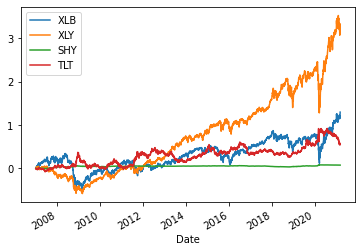

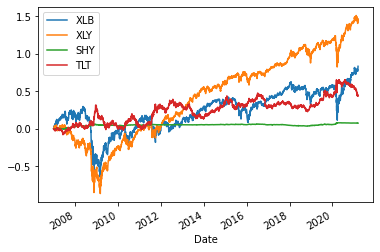

In [3]:
price = raw_price / raw_price.iloc[0] - 1
log_scaled_price = np.log(raw_price / raw_price.iloc[0])

price.loc[:, ["XLB", "XLY", "SHY", "TLT"]].plot()
log_scaled_price.loc[:, ["XLB", "XLY", "SHY", "TLT"]].plot()

동일한 기준에서 패턴 분류를 위해 각 자산의 가격 데이터를 정규화한다. <br>

scaled_price = (log price - mean log price) / sd(log price)

12개월의 가격데이터로 패턴을 분류할 것이기 때문에 평균과 분산은 1년을 기준으로 한다. <br>
<br>
raw 데이터, log 스케일 데이터, 표준화된 데이터를 그려본 결과는 아래와 같다. 상대적으로 변동성이 낮은 단기 채권인 SHY를 자세히 보자. 표준화된 데이터를 사용을 통해 가격 패턴을 동일 선상에서 비교할 수 있다. 패턴을 함수형 데이터로 변환 후 PCA로 분류 시 편향된 결과를 얻지 않을 수 있다.

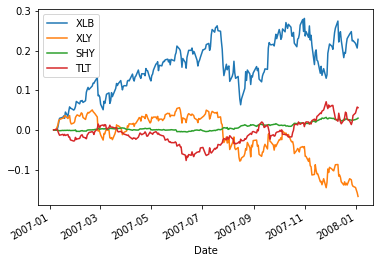

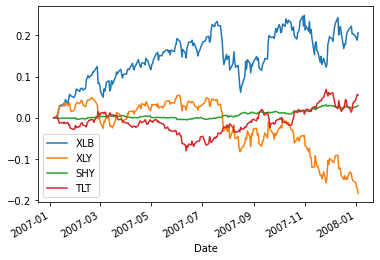

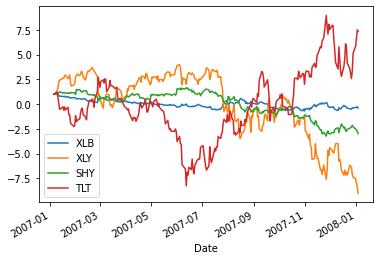

In [4]:
# 2007-01-05부터 1년 (252일)간 가격 데이터 예시
# Mean
tmp_log_price = log_scaled_price.iloc[0:251,]
mean_log_price = tmp_log_price.mean()
sd_log_price = tmp_log_price.std()
scaled_price = (tmp_log_price - mean_log_price) / sd_log_price
price_1year = scaled_price / scaled_price.iloc[0]

price.iloc[0:251,].loc[:, ["XLB", "XLY", "SHY", "TLT"]].plot()
tmp_log_price.loc[:, ["XLB", "XLY", "SHY", "TLT"]].plot()
price_1year.loc[:, ["XLB", "XLY", "SHY", "TLT"]].plot()

##### **분류를 위한 가격 패턴 만들기**
15개의 자산에 대한 시계열을 1년 252일 기준 2주 단위로 잘라 가격 패턴 덩어리를 만든다. 자산 구분없이 금융시장에 2007년 1월 부터 존재하는 최근까지 존재하는 모든 패턴의 집합을 만들어 분류하기 위함이다.

In [66]:
# Get weekly return
price_df = dropna_df # original data
weekly_seq = [i for i in range(len(price_df)) if (i % 5 == 0)]
weekly_dt_idx = price_df.index[weekly_seq]
weekly_return = price_df.loc[weekly_dt_idx].pct_change().dropna()

# Make price pattern function: get_price
def get_price(w_return, n_week = 4*12, n_future = 4, jump = 4):

  split_seq = [i for i in range(n_week, len(w_return) - jump - n_future) if (i % jump == 0)]
  pattern_dict = {}
  dict_idx = 0
  # make price pattern info data
  for s in split_seq:
    partial_return = w_return.iloc[(s-(n_week)):s]
    future_return = w_return.iloc[s:s+n_future-1]
    
    # get price pattern info: log_price, log_mean, log_sd ...
    partial_cumprod_price = (1 + partial_return).cumprod()
    log_price = np.log(partial_cumprod_price)
    log_price_mean = log_price.mean()
    log_price_sd = log_price.std()
    mean_sd_scaled_price = (log_price - log_price_mean) / log_price_sd

    # get future price info
    future_price = (1 + future_return).cumprod()
    future_std_return = np.exp(np.log(1+future_return).mean()) ** n_future - 1 # monthly standardized return
    
    # get date info
    date_index = partial_return.index
    f_date_index = future_return.index

    # Make dictionary
    for t in partial_return.columns:
      dict_idx += 1
    #   if t == partial_return.columns[0]:
    #     break
    #   else:
    #     continue
    # if s == split_seq[0]:
    #   break
    # else:
    #   continue
      
      pattern_dict[dict_idx] = {'ticker': t,
                                'date_index': date_index,
                                'f_date_index': f_date_index,
                                'log_price_mean': log_price_mean.loc[t, ],
                                'log_price_sd': log_price_sd.loc[t, ],
                                'f_std_return': future_std_return.loc[t, ],
                                'price': [{
                                    'org_price': partial_cumprod_price.loc[:, t],
                                    'log_price': log_price.loc[:, t],
                                    'scaled_price': mean_sd_scaled_price.loc[:, t]
                                }]}
  return pattern_dict

# Price pattern dictionary
price_dicts = get_price(weekly_return)

### 1.3 FDA (Functional Data Analysis)
#### **함수형 데이터 (Functional Data) 로 변환하기**

1. B-Spline Basis 사용해 함수형 데이터를 만든다.

In [ ]:
# Aggregate all price pattern from price dictionary


## 2. Frog in the pan 참고자료를 통해 각 패턴의 향후 수익 지속성 및 한달 후 수익 결과 확인

### 2.1 frog in the pan 첨부해 간략히 어떤 내용인지 설명

### 2.2 위에서 클러스터링 한 패턴들의 향후 1달 수익률 및 수익을 지속하는 평균 개월수 구한다.